## 1. Multinomial logistic regression and cross validation

In [141]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.interpolate import LSQUnivariateSpline

In [68]:
df = pd.read_csv('strongdrink.txt')
df.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [70]:
df['cultivar'].value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

### (a)

In [74]:
y = df['cultivar']
X = df[['alco', 'malic', 'tot_phen', 'color_int']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

In [79]:
LogReg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [80]:
print(LogReg.intercept_)
print(LogReg.coef_)

[-24.01128242  22.80206258   1.20921984]
[[ 1.70042769 -0.26560794  1.22389498  0.02275109]
 [-1.46801434 -0.33305171  0.66400722 -0.92271019]
 [-0.23241292  0.59865975 -1.8879021   0.89995934]]


For j = 1, beta0 = -24.01128242, beta1 = 1.70042769, beta2 = -0.26560794, beta3 = 1.22389498, beta4 = 0.02275109

For j = 2, beta0 = 22.80206258, beta1 = -1.46801434, beta2 = -0.33305171, beta3 = 0.66400722, beta4 = -0.92271019

In [82]:
y_pred = LogReg.predict(X_test)

In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       1.00      0.90      0.95        21
           3       1.00      1.00      1.00        10

   micro avg       0.95      0.95      0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44



The error rates are 0.13, 0, and 0 for j = 1, 2, 3, respectively.

The model is best at predicting j = 3 of cultivar, because it has the highest f1-score.

j = 2 has the most oberservations, but j = 3 is the most accurately predicted category. So the most accurately predicted category is not the one with the most obeservations.

In [84]:
MSE = mean_squared_error(y_test, y_pred)

print("Validation set MSE = ", MSE)

Validation set MSE =  0.045454545454545456


### (b)

In [85]:
X = df[['alco', 'malic', 'tot_phen', 'color_int']].values
y = df['cultivar'].values

N_loo = X.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(X)
MSE_vec = np.zeros(N_loo)

y_t = np.zeros(X.shape[0])
y_p = np.zeros(X.shape[0])

In [86]:
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t[test_index] = y_test
    LogReg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    y_p[test_index] = y_pred
    if y_test == y_pred:
        MSE_vec[test_index] = 0
    else:
        MSE_vec[test_index] = 1

In [87]:
MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print("test estimate MSE loocv = ", MSE_loo)
print("test estimate MSE standard err = ", MSE_loo_std)

test estimate MSE loocv =  0.07954545454545454
test estimate MSE standard err =  0.2705882022679695


In [88]:
print(classification_report(y_t, y_p))

              precision    recall  f1-score   support

         1.0       0.90      0.93      0.92        59
         2.0       0.91      0.90      0.91        71
         3.0       0.96      0.93      0.95        46

   micro avg       0.92      0.92      0.92       176
   macro avg       0.92      0.92      0.92       176
weighted avg       0.92      0.92      0.92       176



The error rates are 0.1, 0.09, and 0.04 for j = 1, 2, 3, respectively.

Compared to (a), the error rates for j = 1 decreases from 0.13 to 0.1, but the error rates for group 2 and 3 increase.

### (c)

In [89]:
k = 4

kf = KFold(n_splits=k, shuffle=True, random_state=10)
kf.get_n_splits(X)

4

In [90]:
MSE_vec_kf = np.zeros(k)
k_ind = int(0)

y_t = np.zeros(len(y))
y_p = np.zeros(len(y))

In [91]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t[test_index] = y_test
    LogReg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    y_p[test_index] = y_pred
    err = [1 if y_test[i] != y_pred[i] else 0 for i in range(len(y_pred))]
    MSE_vec_kf[k_ind] = np.mean(err)
    k_ind += 1

In [92]:
MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print("test estimate MSE k-fold = ", MSE_kf)
print("test estimate MSE standard err = ", MSE_kf_std)

test estimate MSE k-fold =  0.09090909090909091
test estimate MSE standard err =  0.04821182598999188


In [93]:
print(classification_report(y_t, y_p))

              precision    recall  f1-score   support

         1.0       0.87      0.93      0.90        59
         2.0       0.91      0.87      0.89        71
         3.0       0.96      0.93      0.95        46

   micro avg       0.91      0.91      0.91       176
   macro avg       0.91      0.91      0.91       176
weighted avg       0.91      0.91      0.91       176



The error rate for j = 1 is: 1 - 0.87 = 0.13

The error rate for j = 2 is: 1 - 0.91 = 0.09

The error rate for j = 3 is: 1 - 0.96 = 0.04

Compared to (a), the error rates for j = 1 decreases from 0.13 to 0.1, but the error rates for group 2 and 3 increase. Compared to (b), the error rate for j = 1 increases from 0.1 to 0.13, but the error rates for j = 2, 3 remain the same.

## 2. Splines and interpolation

In [99]:
df2 = pd.read_csv("CoolIndex.txt", names=['age', 'CI'])
df2.head()

,age,CI
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


### (a)

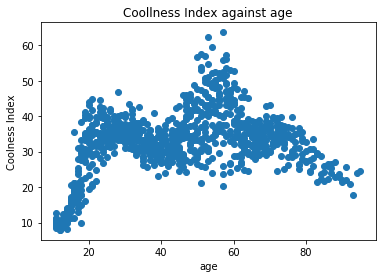

In [101]:
X = df2['age']
y = df2['CI']

plt.scatter(X, y)
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coollness Index against age")
plt.show()

### (b)

In [121]:
df2['bin1'] = np.where((df2.age>=11) & (df2.age<22), 1, 0)
df2['bin2'] = np.where((df2.age>=22) & (df2.age<40), 1, 0)
df2['bin3'] = np.where((df2.age>=40) & (df2.age<59), 1, 0)
df2['bin4'] = np.where((df2.age>=59) & (df2.age<77), 1, 0)
df2['bin5'] = np.where((df2.age>=77) & (df2.age<=95), 1, 0)

In [135]:
X = df2[['bin1', 'bin2', 'bin3', 'bin4', 'bin5']]
y = df2['CI']
ols = sm.OLS(y, X).fit()

In [137]:
y_pred = result.predict()

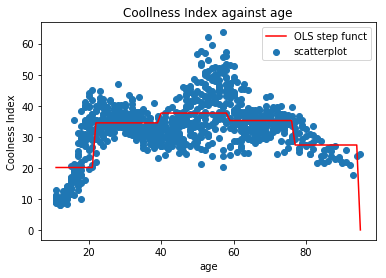

In [167]:
X = df2['age']

plt.clf()
plt.scatter(X, y,label='scatterplot')
plt.plot(X, y_pred, color='r', label='OLS step funct')
plt.legend()
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coollness Index against age")
plt.show()

In [168]:
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                     CI   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Wed, 26 Feb 2020   Prob (F-statistic):          3.73e-114
Time:                        06:14:12   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bin1          20.1025      0.562     35.746      0.0

The estimated step function values are: $\beta_{1}$ = 20.1025, $\beta_{2}$ = 34.4758, $\beta_{3}$ = 37.6351, $\beta_{4}$ = 35.2254, $\beta_{5}$ = 27.2964

In [169]:
ols.predict([0, 0, 0, 1, 0])

array([35.22540004])

The predicted collness of a 73-year old from the stepwise function is 35.22540004.

### (c)

In [171]:
df2_2 = df2.groupby('age').mean()
df2_2['age'] = df2_2.index
df2_2.head()

,CI,bin1,bin2,bin3,bin4,bin5,age
age,,,,,,,
11.0,10.110237,1,0,0,0,0,11.0
12.0,9.365623,1,0,0,0,0,12.0
13.0,10.015882,1,0,0,0,0,13.0
14.0,11.747109,1,0,0,0,0,14.0
15.0,15.434739,1,0,0,0,0,15.0


In [172]:
knots = [22, 40, 59, 77]
linear = LSQUnivariateSpline(np.array(df2_2['age']), np.array(df2_2['CI']), t=knots, k=1)

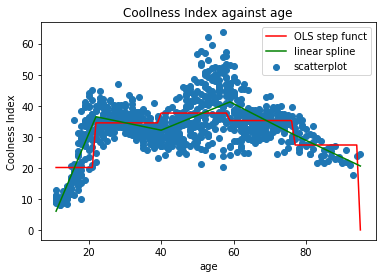

In [173]:
plt.clf()
plt.scatter(X, y,label='scatterplot')
plt.plot(X, y_pred, color='r', label='OLS step funct')
plt.plot(df2_2.age, linear(df2_2.age), color='g', label='linear spline')
plt.legend()
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coollness Index against age")
plt.show()

In [174]:
linear(73)

array(32.86784862)

The predicted coolness of a 73-year old from the linear spline is 32.86784862

### (c)

In [175]:
cubic = LSQUnivariateSpline(np.array(df2_2['age']), np.array(df2_2['CI']), t=knots, k=3)

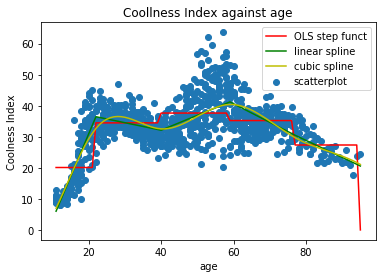

In [176]:
plt.clf()
plt.scatter(X, y,label='scatterplot')
plt.plot(X, y_pred, color='r', label='OLS step funct')
plt.plot(df2_2.age, linear(df2_2.age), color='g', label='linear spline')
plt.plot(df2_2.age, cubic(df2_2.age), color='y', label='cubic spline')
plt.legend()
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coollness Index against age")
plt.show()

In [177]:
cubic(73)

array(32.64230107)

The predicted coolness of a 73-year old from the cubic spline is 32.64230107